<a href="https://colab.research.google.com/github/em2tech/hello-world/blob/main/Assignment_2_Image_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Generation with a Diffuser Model**

* We need to install the following libraries:

   1. **diffusers**: This is the core library that contains the Stable **Diffusion Pipeline**.

   2. **transformers**: This provides the **CLIP model**, which acts as the translator between the text prompt and the image generator.

   3. **accelerate**: This helps handle the heavy mathematical lifting on the GPU.
   
   4. Make sure to ask for a GPU to run this norebook:

   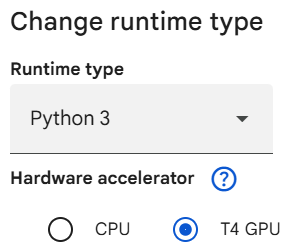



In [1]:
# the needed libraries
!pip install diffusers transformers accelerate



In [2]:
import diffusers
import os

# Disable the problematic progress bar widgets
diffusers.logging.disable_progress_bar()
os.environ["TQDM_DISABLE"] = "1"

# **The Running Environment**

1. We first go to the **Hugging Face Model Hub** and download all the AI models such as the VAE, the **CLIP** tokenizer, etc.

2. **CLIP** stands for **Contrastive Language-Image Pre-training**
   * A model developed by OpenAI that acts as a bridge between **words** and **pictures**.
   
   * **CLIP** was trained by looking at 400 million pairs of images and their captions from the internet to learn how they relate.

   * E.g. If you show it a **photo of a dog** and **the text "a photo of a dog,"** it learns to push those together in its **latent space**.

2. We then move the 4GB+ of model weights from the computer's general memory into the Graphics Card's memory.

3. A CPU might take 5 minutes to make one image but aa CUDA-enabled GPU (NVIDIA) can do it in 2 seconds.

In [3]:
import torch
from diffusers import StableDiffusionPipeline

# Load the model into memory
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16
).to("cuda")





Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/396 [00:00<?, ?it/s]

StableDiffusionSafetyChecker LOAD REPORT from: /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/safety_checker
Key                                               | Status     |  | 
--------------------------------------------------+------------+--+-
vision_model.vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


# **The Sculptor**

* **Stable Diffusion** creates images by starting with some noise and slowly cleaning it up.

* The **seed** is the number that determines exactly what that static looks like before the AI starts its work. So, if you use Seed 42, the formula always spits out the exact same pattern of noise.


* **num_inference_steps** is the most important parameter here

* It tells the AI how many times to **chip away** at the noise.

    * **1-10 Steps**: You'll see blurry blobs

    * **20-50 Steps**: You'll see sharper details and textures

* **Note**:

  * **CLIP**, the **translator**, uses **Visual Tokens** (14x14 patches).
  * It needs them to **read** an image so it can match it to a caption.
  * **Stable Diffusion**, the **sculptor**, uses a **Latent Space**.


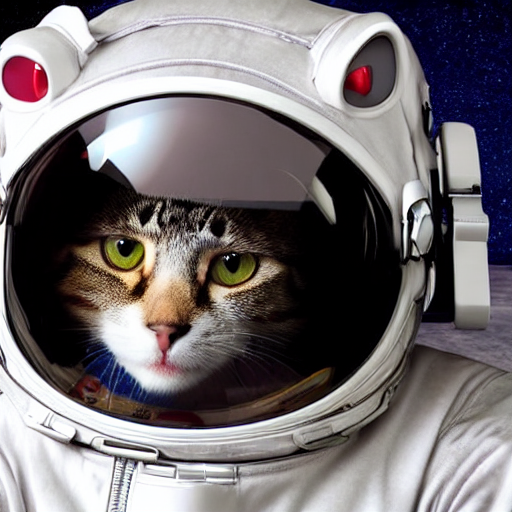

In [4]:
# Create a generator with a fixed seed
generator = torch.Generator("cuda").manual_seed(60)

pipe.set_progress_bar_config(disable=True)

image = pipe(
    prompt = "a cat in spacesuit",
    generator=generator,
    num_inference_steps=50
).images[0]

image

# **Image Diffusion in Steps**

---
1. **Training or the "Learning" process**

 * We teach the AI to be a **restorer**
 * We take a perfectly clear image
 * We intentionally destroy it by **adding layers of random Gaussian noise (epsilon)** until it is unrecognizable:

 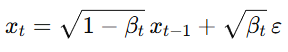

* Where,
  * X_t-1 is the image at the previous step
  * X_t is the image afteradding noise
  * beta_t is how much noise we want to add

 * We show the AI **each noisy image** and **the actual noise** we added.
 * We then ask: **"Can you predict exactly what noise I just added?"**

  * The AI gets better and better at identifying the  **signature** of noise versus the **signature** of a cat

---
**2. Generation or the "Creative" process**

* We start with a **block of pure noise** with a  random seed
* **CLIP** takes the prompt and tells the image **sculptor** what to look for in that noise.

 * The **sculptor** looks at the noise and decides **some of this noise looks like a cat's ear**. It then predicts that noise and subtracts it.

 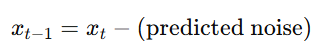

 * This happens 30–50 times, while each step makes the image slightly cleaner until the final image is produced.

 ---


 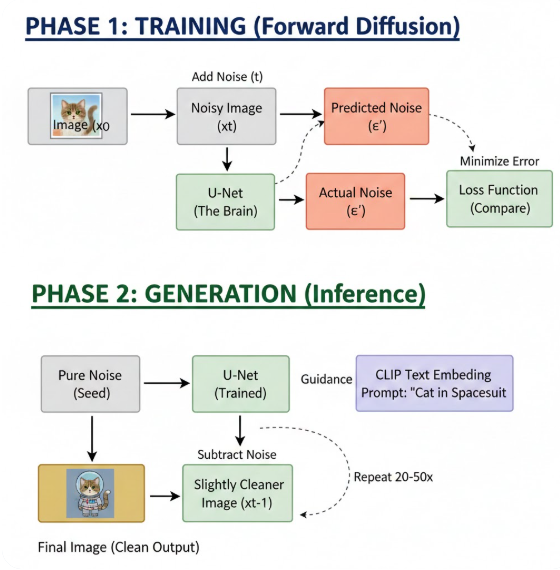



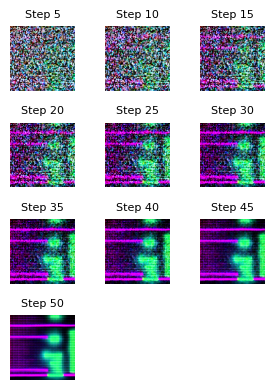

In [7]:
import torch
import matplotlib.pyplot as plt

generator = torch.Generator("cuda").manual_seed(60)
intermediate_images = []

def latents_callback(pipe, step_index, timestep, callback_kwargs):
    # Capture every 5 iterations
    if (step_index + 1) % 5  == 0:
        latents = callback_kwargs["latents"]
        with torch.no_grad():
            # Decode and process latent to PIL
            latents = 1 / 0.18215 * latents
            image = pipe.vae.decode(latents).sample
            image = (image / 2 + 0.5).clamp(0, 1)
            image = image.cpu().permute(0, 2, 3, 1).float().numpy()
            pil_image = pipe.numpy_to_pil(image)[0]
            intermediate_images.append((step_index + 1, pil_image))

    return callback_kwargs

# Run the generation
final_image = pipe(
    prompt="A cyberpunk hacker terminal showing green lines of code, reflection of a neon city on the screen, 8k, raytracing.",
    generator=generator,
    guidance_scale= 30,
    num_inference_steps=50,
    callback_on_step_end=latents_callback,
    callback_on_step_end_tensor_inputs=['latents']
).images[0]

# Add the final result to our list
#intermediate_images.append((50, final_image))

# --- Display in a Matrix ---
cols = 3
rows = (len(intermediate_images) + cols - 1) // cols
# figsize is (width, height) in inches.
# Since we want roughly 1x1 inch images, we scale by the grid size.
plt.figure(figsize=(cols, rows))

for i, (step, img) in enumerate(intermediate_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(f"Step {step}", fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()